![](https://dunazo.oss-cn-beijing.aliyuncs.com/blog/WRSDP-3-2.png)

<p align="justify ">2022年多家媒体报道了鄱阳湖遭遇极端旱情的新闻，印象中上一个关于鄱阳湖的新闻还是2020年的洪灾。2022年短短的几个月时间鄱阳湖到底发生了怎样的变化，哨兵2号光学数据在该区域6-9月份可用数据有限，因此让我们用哨兵1号雷达数据来一探究竟。<p>

# 练习2 基于雷达数据的水体变化监测
### 1. 方法介绍

<p align="justify ">哨兵1号卫星是欧空局哥白尼计划（GMES）中的地球观测卫星，由A、B两颗卫星组成，载有C波段合成孔径雷达，可提供连续图像(白天、夜晚和各种天气)。近年来，哨兵1号卫星在海冰测绘，水体变化监测，地面沉降调查，地质灾害隐患识别等应用领域发挥了重要作用。中国是目前拥有哨兵系列卫星用户最多的国家，希望大家在充分利用数据资源做好研究的同时，也要提倡和鼓励欧空局这种开源共享的精神。<p>

<p align="justify ">主要思路是构建SDWI指数，通过阈值法提取单期水体分布范围，在置信度较高的区域进行采样训练随机森林网络，将模型应用多期影像完成水面的提取。<p>


SDWI指数计算公式:      
<font size=2>$$    SDWI = ln(k × VV × VH) +s $$</font>	

<p align="justify ">式中$VV$和$VH$为极化影像，$k$为增益系数一般取10即可，$s$为初始阈值，主要思想是利用$vv$、$vh$与$k$的乘积扩大水体与其他地物之间的差异，初始阈值需根据统计结果进行估计(接近8的值)。<p>

<p align="justify ">大津法也是常用水体提取方法之一，其核心是目标与背景的统计值形成双峰效果才好，这要求统计目标与背景面积尽可能相近，但实际应用中会遇到一些复杂的情况，比如小块水体较多，或目标面积较小等场景应用效果不理想，本案例也列举了类似的情况。<p>

<p align="justify ">[Otsu](http://en.wikipedia.org/wiki/Otsu%27s_method)也被称为最大类间方差法，其基本原理是假设检测图像有前景和背景两部分组成，通过统计学方法找出合适的阈值，使得前景和背景组大程度被区分开。<p>

1. 最小化类内方差 (定义为两类方差的加权和):

 <font size=2>$$\sigma^2_w(t)=\omega_1(t)\sigma^2_1(t)+\omega_2(t)\sigma^2_2(t)$$</font>	

2. 最大化类间方差:

 <font size=2>$$\sigma^2_b(t)=\sigma^2-\sigma^2_w(t)=\omega_1(t)\omega_2(t)\left[\mu_1(t)-\mu_2(t)\right]^2$$</font>


$\omega_i$ 是两个类别的权重.   $\mu_i$ and $\sigma^2_ i$ 分别是两个类的均值和方差

### 2. 时序数据加载及处理

加载必要的库函数

In [167]:
import glob, cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from osgeo import gdal, osr, ogr, gdalconst
import os,glob,time,rasterio
from random import shuffle


定义读写数据函数

In [166]:
## 读图像文件
def read_img(filename):
    dataset = gdal.Open(filename)  # 打开文件
    im_width = dataset.RasterXSize  # 栅格矩阵的列数
    im_height = dataset.RasterYSize  # 栅格矩阵的行数
    # im_bands = dataset.RasterCount  # 波段数
    im_geotrans = dataset.GetGeoTransform()  # 仿射矩阵，左上角像素的大地坐标和像素分辨率
    im_proj = dataset.GetProjection()  # 地图投影信息，字符串表示
    im_data = dataset.ReadAsArray(0, 0, im_width, im_height)
    del dataset   #关闭对象dataset，释放内存
    # return im_width, im_height, im_proj, im_geotrans, im_data,im_bands
    return  im_data
## 计算sdwi，输入是包含vv和vh的2波段影像
def cal_sdwi(data):
    return np.log(data[0]*data[1]*10)
## 通过文件名分割将8个数据分成4组，利用每组的vv和vh计算sdwi指数，得到4组sdwi
def sdwi_combin(n,filelist):
    data_all=[]
    for j in range(4):
        data=[]
        for i, file in zip(range(n),filelist):
            [dirname,filename]=os.path.split(file) 
            (shotname,extension) = os.path.splitext(filename)
            keywd=shotname.split('_')[1:3]  #根据文件名的规律提取分组信息
            if keywd[0]==str(j):
                data.append(read_img(file))
        sdwi=cal_sdwi(np.array(data))
        data_all.append(sdwi) 
    return np.array(data_all)
## 给定阈值得到二值化影像
def threshold_seg(sdwi,threshold,switch=False):
    tmp = sdwi.copy()
    if switch:
        tmp [tmp<=threshold] = 1
        tmp [tmp>threshold] = 0
    else:
        tmp [tmp<=threshold] = 0
        tmp [tmp>threshold] = 1
    return np.uint8(tmp)
## 将数据归一化至0-10000的16位整型数据
def norm(band):
    band=np.array(band,dtype=np.float32)
    c = np.min(band)
    d = np.max(band)       
    out =  (band - c)  / (d - c)  
    return (out*10000).astype(np.uint16)

用glob检索已下载的哨兵1号数据


In [4]:
infolder='./data./SAR/'
filelist=glob.glob(infolder+'sentinel*.tif')
n=len(filelist)
print(n)

8


通过文件名，将8个数据分成4组，利用每组的vv和vh计算sdwi指数，得到4组sdwi，查看每个sdwi的数值范围

In [141]:
sdwi_all=sdwi_combin(n,filelist)
sdwi_all=np.nan_to_num(sdwi_all) #用于去掉数据中存在的nan值，具体根据数据情况选用，非必须
for file in sdwi_all:
    print(np.min(file),np.max(file),np.mean(file))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14988\4195819107.py:15: RuntimeWarning: invalid value encountered in log
  return np.log(data[0]*data[1]*10)


-6.927577496468431 9.236756509679683 7.749823511700255
-7.636165228292373 9.345565288117363 7.6522570937515555
-8.768979387575639 9.068931540870791 7.604430906820028
-8.02139217881955 9.086487657590412 7.632414847347485


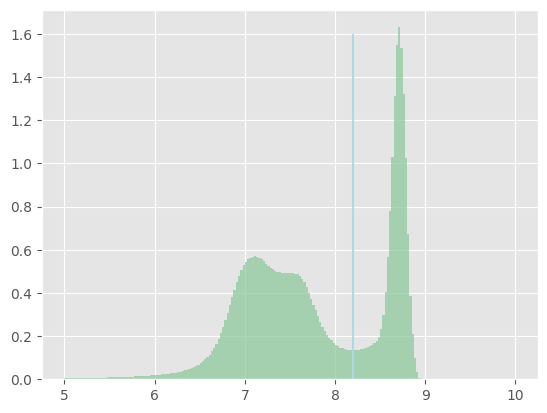

In [12]:
plt.style.use('ggplot')
plt.hist(sdwi_all[0].ravel(), bins=200, range=[5,10],density=True, facecolor='#8fca9e', alpha=0.75)
plt.vlines(8.2, ymin = 0, ymax = 1.6, colors = 'lightblue')
plt.show()

通过直方图可见数据中水陆分界的位置在8.2左右，因此这里可以直接用阈值法得到分割结果

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14988\3003795320.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1),plt.title('SAR_VV'), plt.axis('off')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14988\3003795320.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,2),plt.title('SDWI'), plt.axis('off')


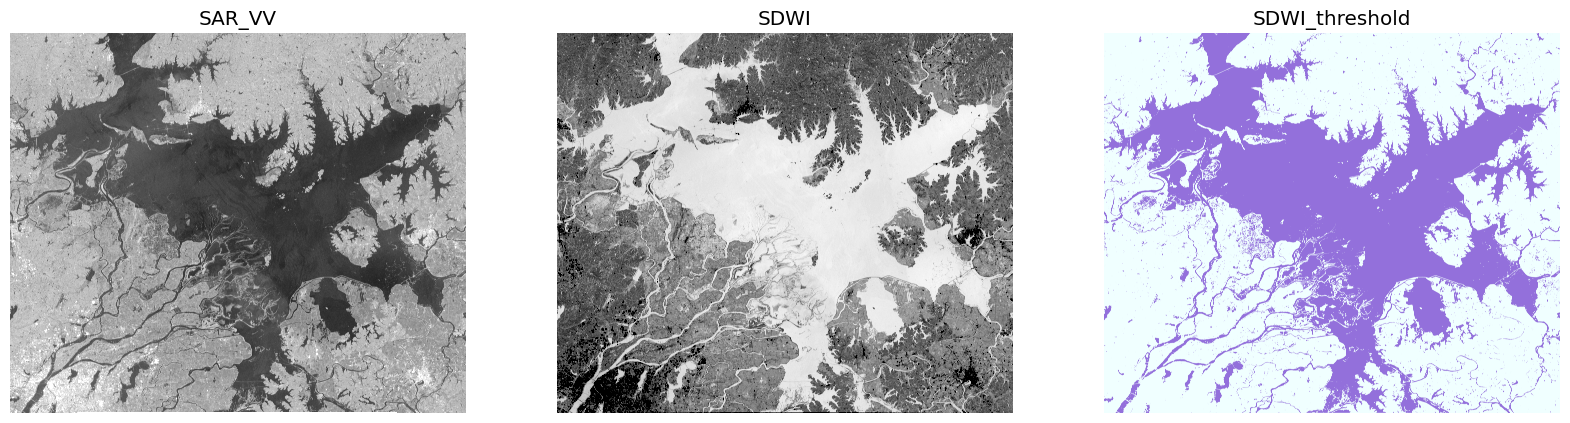

In [13]:
firstvv=read_img(filelist[1])
threresult=threshold_seg(sdwi_all[0],8.2)
palette = np.array([ [240, 255, 255],[147, 112, 219]]) #自定义colorbar，用于分类结果的显示，非常实用
color=palette[threresult]
fig, axes = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,3,1),plt.title('SAR_VV'), plt.axis('off')
plt.imshow(firstvv,cmap='gray',vmin=-30,vmax=0),plt.axis('off')
plt.subplot(1,3,2),plt.title('SDWI'), plt.axis('off')
plt.imshow(sdwi_all[0],cmap='gray',vmin=6,vmax=9)
plt.subplot(1,3,3),plt.title('SDWI_threshold'), plt.axis('off')
plt.imshow(color)   

### 2. 大津法分割

直方图显示数值呈现出较好的“双峰”特征，对于这种示范区范围并不大的情况下可以采用大津法，从而避免人工设定阈值。

In [14]:
img=norm(sdwi_all[0].copy()) #将数据转换成0-10000的16位浮点型数据，边用用cv2函数进行计算，虽然cv常用来处理uint8的数据，但此处不建议归一化至0-255会一定程度丢失信息。
ret2,th2 = cv2.threshold(img,0,10000,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret2)
color2=palette[np.uint8(th2/10000)]


9143.0


大津法结果与人工分割结果整体较为接近，但阈值选择偏保守，导致碎斑更多，用高斯滤波优化一些效果更好一些

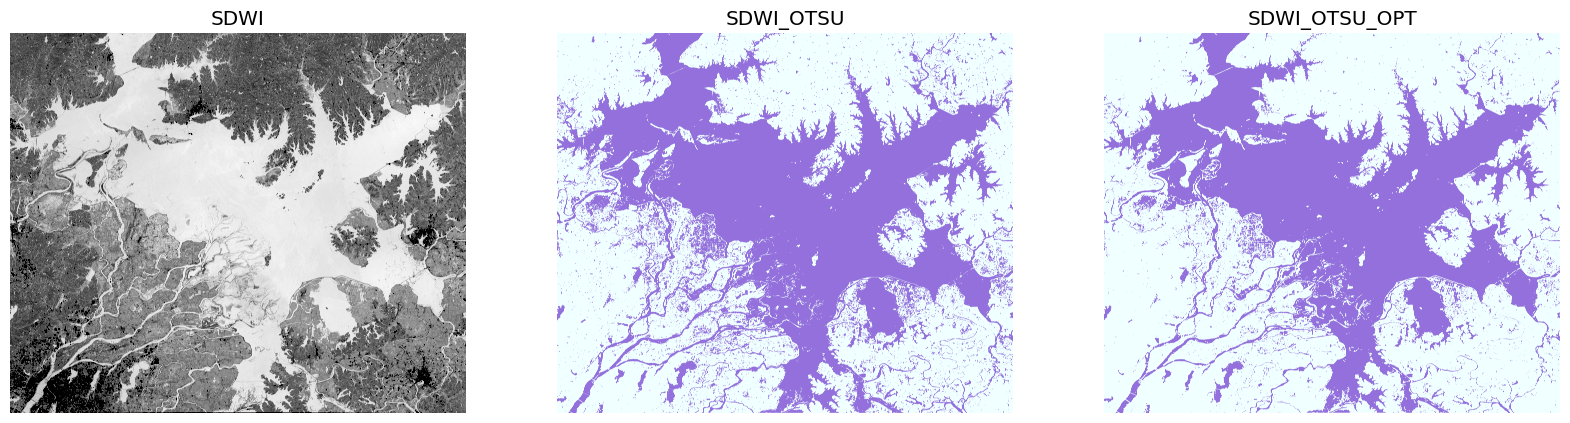

In [15]:
blur = cv2.GaussianBlur(th2,(7,7),0)
color3=palette[np.uint8(blur/10000)]

fig, axes = plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1),plt.title('SDWI'), plt.axis('off')
plt.imshow(sdwi_all[0],cmap='gray',vmin=6,vmax=9)
plt.subplot(1,3,2),plt.title('SDWI_OTSU'), plt.axis('off')
plt.imshow(color2)
plt.subplot(1,3,3),plt.title('SDWI_OTSU_OPT'), plt.axis('off')
plt.imshow(color3)

如果示范区范围大，全局采用大津法并不是很好的选择，因为不能保证呈现出很好的“双峰”特征，虽然可以通过对每个目标进行标记，再利用循环的方式对每一个目标做buffer来实现局部OTSU，但当有很多细碎的小目标存在时，依然难以做到准确快捷。

本例中，从直方图分析阈值设定在9650是较为合适的，而otsu寻找到的是9154，因而随着鄱阳湖的持续干旱，水面逐渐缩小，裸露出来的河滩逐渐增多，导致直方图中水陆的界限不再分明的呈现“双峰”式，从而使面积较小的水体信息在统计中被淹没了，因而结果是错误的

9154.0


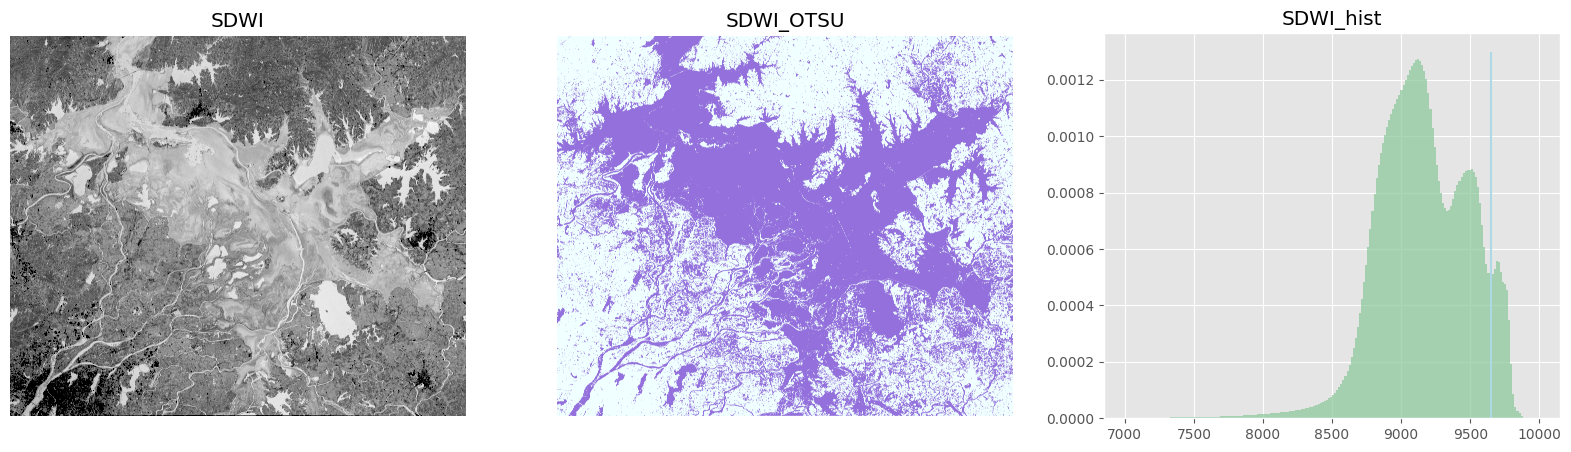

In [47]:
img=norm(sdwi_all[-1].copy()) #将数据转换成0-10000的16位浮点型数据，边用用cv2函数进行计算，虽然cv常用来处理uint8的数据，但此处不建议归一化至0-255会一定程度丢失信息。
ret4,th4 = cv2.threshold(img,0,10000,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret4)
color3=palette[np.uint8(th4/10000)]

fig, axes = plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1),plt.title('SDWI'), plt.axis('off')
plt.imshow(sdwi_all[-1],cmap='gray',vmin=6,vmax=9)
plt.subplot(1,3,2),plt.title('SDWI_OTSU'), plt.axis('off')
plt.imshow(color3)
plt.subplot(1,3,3),plt.title('SDWI_hist'), plt.axis('off')
plt.hist(img.ravel(), bins=200, range=[7000,10000],density=True, facecolor='#8fca9e', alpha=0.75)
plt.vlines(9650, ymin = 0, ymax = 0.0013, colors = 'lightblue'),plt.axis('on')
plt.show()

### 3. 随机森林分类


用机器学习的方法的关键在于样本的选择，这里我们通过设定较大的阈值将置信度高的水体信息提取出来作为正样本的采样区，设定相对小的阈值将确定的非水体信息提取出来作为负样本

In [168]:
## 数据叠加
def concat(img1,img2):
    img1=np.expand_dims(img1,axis=-1) #数据维度扩增，axis表示扩增的位置，0为第一位
    img2=np.expand_dims(img2,axis=-1)
    return np.concatenate((img1,img2),axis=-1)
## 阈值分割，注意switch为false是将高值设为1，为true的时候将低值设为1，见threshold_seg说明
def thre_seg(dataall,threshold,switch=False):
    result=[]
    for img in dataall:
        norm_img=norm(img.copy()) 
        thimg =threshold_seg(norm_img,threshold,switch=switch) 
        temp=concat(norm_img,thimg)
        result.append(temp)
    return np.array(result)
## 随机裁剪是以随机点为起始点裁剪，切片数可以是无限的且可自定义，后者的好处是可以通过增加算法约束label中某一类的数量来实现精准的样本获取。
def random_crop(image,crop_sz):
    img_sz=image.shape[:2]
    random_x = np.random.randint(0,img_sz[0]-crop_sz+1) ##生成随机点
    random_y = np.random.randint(0,img_sz[1]-crop_sz+1)
    s_img = image[random_x:random_x+crop_sz,random_y:random_y+crop_sz,:] ##以随机点为起始点生成样本框，进行切片
    return s_img
## 随机裁剪n_patch表示每个数据裁多少块，n为最多循环多少次，如果n=5000，在5000次内依然没有检索到足够的数据实际结果将小于n_patch
def data_crop(imagearray,crop_sz,n_patch=300,n=5000):   
    n_file=imagearray.shape[0]
    data_all = []
    for i in np.arange(n_file):
        data = []
        x=0
        for j in np.arange(n):
            image=random_crop(imagearray[i,:,:,:],crop_sz)
            if np.mean(image[:,:,-1])==1:  #这里通过设定均值都为1才提取，表示32×32方框内均为水体
                data.append(image)
                x=x+1
                if x % 50 ==0:
                    print("processing....patch:"+str(i)+"...No.:"+str(x))
                if x == n_patch:
                    break
        data=np.array(data)
        if i == 0:
            data_all = data
        else:
            data_all=np.concatenate((data_all, data), axis = 0)
    return data_all
## 随机打散数据
def suffle_data(imgd):
    index = [i for i in range(len(imgd))]
    shuffle(index)
    newimg = imgd[index, :, :, :]
    return newimg


分别对确定为水体和确定为非水体的区域用传统阈值分割法进行提取，下面阈值根据前面直方图大致估计得出。
做完回看的时候这里的阈值设定还可以进一步优化，9月份裸露的大面积河滩可以作为苦难样本单独采样，训练样本会更准确

In [157]:
thredata1=thre_seg(sdwi_all,9650)
thredata2=thre_seg(sdwi_all,9400,switch=True)

(4, 9127, 10946, 2)

分别在两个区域内容随机采样，这里采用32×32，并没有实际意义，没用像素采样的原因是整个随机采样程序与可以用在深度学习的切片采样上，一劳永逸

In [160]:
random1_pic=data_crop(thredata,32)
print(random1_pic.shape)
random2_pic=data_crop(thredata2,32,n_patch=150)
random2_pic[:,:,:,1]=0 #这里因为randomw2_pic中的真值还是1，但它是对非水体区域采集的负样本，所以重新设置了它的真值为0
print(random2_pic.shape)

processing....patch:0...No.:50
processing....patch:0...No.:100
processing....patch:0...No.:150
processing....patch:1...No.:50
processing....patch:1...No.:100
processing....patch:1...No.:150
processing....patch:2...No.:50
processing....patch:2...No.:100
processing....patch:2...No.:150
processing....patch:3...No.:50
processing....patch:3...No.:100
processing....patch:3...No.:150
(600, 32, 32, 2)


训练样本合并随机处理

In [178]:
traindata=np.concatenate((random1_pic,random2_pic),axis=0)
traindata=suffle_data(traindata)

In [ ]:
## 预测输入数据预处理
def data_process(image):
    norm_img=norm(image.copy())
    resize=np.expand_dims(norm_img.ravel(),axis=-1)
    return resize 
## 预测结果reshape
def data_reshape(result,image):
    return result.reshape(image.shape[0],image.shape[1])
## 循环推理
def prediction(sdwi_all):
    pred=[]
    for img in sdwi_all:
        result=model.predict(data_process(img))
        pred_r=data_reshape(result,img)
        pred.append(pred_r)
    return np.array(pred)

载入随机森林算法，喂训练数据进行训练，这里也可以采用其他机器学习模型，选择随机森林的原因是其速度和精度二者较为平衡，是性价比很高的ML算法

In [184]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, bootstrap = True,max_features = 'sqrt')
model.fit(np.expand_dims(traindata[:,:,:,0].ravel(),axis=-1), np.expand_dims(traindata[:,:,:,1].ravel(),axis=-1))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14988\445534785.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(np.expand_dims(traindata[:,:,:,0].ravel(),axis=-1), np.expand_dims(traindata[:,:,:,1].ravel(),axis=-1))


RandomForestClassifier()

In [207]:
result=prediction(sdwi_all)


### 3. 水面变化可视化

对提取的鄱阳湖水面信息进行可视化，可见从6月到9月，受旱灾影响，水面持续下降（图中右下角未变化的区域应该不属于鄱阳湖）

In [16]:
def show_4_images(image,title,n=1):
    for k in range(n):
        fig=plt.figure(figsize=(20,5))
        for i in range(4):
            plt.subplot(k+1,4,k*4+i+1)
            plt.imshow((image[k*4+i,:,:,:3]))
            plt.title(title[i])
            plt.axis('off')
        plt.show()

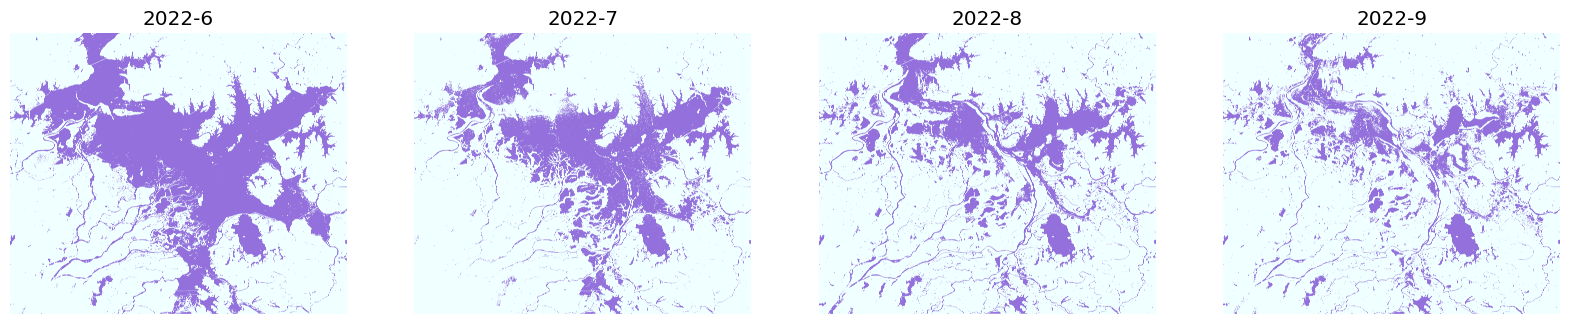

In [212]:
result_show=palette[np.uint8(result)]
show_4_images(result_show,['2022-6','2022-7','2022-8','2022-9'])

最后推荐大家多用GEE来解决问题，上面案例从下载到处理可能需要大半天的时间，而gee做一个全年的水面提取，也就几分钟的事儿，下面是鄱阳湖2022年12个月累计的变化，颜色越浅代表一年内水体存在的时间越短，深蓝色代表永久性水体，这个结果能更直观的看到2022年鄱阳湖的变化情况

![](https://dunazo.oss-cn-beijing.aliyuncs.com/blog/change.JPG)

----------------------------------------
想了解更多请关注[45度科研人]公众号，欢迎给我留言！
<span style="display: block; text-align: center; margin-left: auto; margin-right: auto;">
    <img src="https://dunazo.oss-cn-beijing.aliyuncs.com/blog/wechat-simple.png" width="300"  alt="">
</span>
